# Intro

Up to this point, the graphs we've built have used un-weighted, un-directed edges with just two dimensions - artist and user-tag.  We're now going to explore how we can add an artist popularity weight to the
artist-artist edges and how the weighted edges affect overall graph accuracy / novelty.

We'll need to adjust the original get_edges function to add a key:value pair to the edge attributes.  We will first attempt to use our existing Yahoo! ratings data. By now, the ratings data is probably too old to be used, but it is an almost complete set of ratings (popularity) that should suffice for a proof of concept.  We will start by assigning to an edge a weight that is equal to the mean of Yahoo! rating of the two artists:

Weights will also need to be assigned to the user-tag based edges since networkx will auto assign a weight of 1 to all edges.  For the sake of understand artist rating weights, all user-tag edges will be assigned a weight of .005.

### New edge-finding function:

In [2]:
# Adding weighted artist-artist edges to the existing get_edges function 

def get_edges(dictionary,label, pop_weight = True, weight = 0):
    """Create a list of edges from a dictionary.

    Create a list of labeled edges for a network graph by comparing the values (artists)
    of each key (band) in a dictionary.  If two values share a key, return a list of
    (key,key,{link:shared value}) tuples.  This function is called by the build_net function to
    generate the edge list for graph construction.

    Parameters
    ----------
    dictionary : dict

    label : str
            Label to be used as key in edge metadata, used to describe node relationship.

    Returns
    -------
    edgelist : list of str and dict

    """
    edgelist_raw = []
    for  key, value in dictionary.items():
        for items in value:
            for key1, value1 in dictionary.items():
                for items1 in value1:
                    if len(items) > 1 and len(items1) > 1: # Prevent single letter artists
                                                         # ('G' or 'K') from linking with
                                                         # every artist with a g or k in their name.                        
                        
                        if items in items1:
                            if pop_weight == True:
                                # adding to the edge attributes the average of the Yahoo! rating count between two artists
                                
                                #solve for df having multiple entires for artist ratings
                                if key in ratings.index:
                                    rating1 = ratings.loc[key, 'yahoo_rating_count'].astype(int)
                                    
                                    # TEMP - there may be multiple artists in the ratings file.  if this is the case,
                                    # select the first value in the series.  Remove when ratings file is consolidated. 
                                    if type(rating1) == pd.core.series.Series:
                                        rating1 = list(ratings.loc[key, 'yahoo_rating_count'])[0]
                                else:
                                    rating1 = 1
                                
                                if key1 in ratings.index:
                                    rating2 = ratings.loc[key1, 'yahoo_rating_count'].astype(int)
                                    
                                    if type(rating2) == pd.core.series.Series:
                                        rating2 = list(ratings.loc[key1, 'yahoo_rating_count'])[0]
                                else:
                                    rating2 = 1
                                
                                avg_rating = (rating1 + rating2) / 2 # average rating between two connected artists
                                                                     # ex. The Beatles (1000) <--> The Who (500)
                                                                     # = 750 edge weight.
                                 
                                norm_rating = avg_rating / 783871    # naive normalize average rating onto a 0 - 1 scale.
                                                                     # 783871 is the highest rating in the Yahoo! data
                                
                               # # check to that the edge does not already exist in edge_list
                               # if (key,key1,{label:items, 'weight':norm_rating}) not in edgelist_raw:
                                
                                edgelist_raw.append((key,key1,{label:items, 'weight':norm_rating}))
                            
                            # return edgelist without edge weight passed to function
                            else:
                                edgelist_raw.append((key,key1,{label:items, 'weight':weight}))

    # remove duplicate edges from edgelist_raw
    edgelist = []
    edgelist = [i for i in edgelist_raw if i not in edgelist]
    
    return edgelist


In [3]:
# adding a hard usert-tag edge weight

def add_tag_edges(graph, just_edges=False):
    """Add user tag-based edges to an existing artist network graph.

    Append user tag-based edges to an existing artist graph and return a
    multigraph. Creates edges in the form of (band1,band2,{link:tag})
    tuple.  This function will not add new nodes to the graph.

    Parameters
    ----------
    graph : graph object
            Network graph from which tags will be retrieved, and tag-edges will be added

    just_edges : bool
                 If just_edges = True, return new, undirected multigraph object.
                 If just_edges = False, return list of tag-based edges.

    Returns
    -------
    new_graph : networkX multigraph object

    tag_edges : list of str

    """

    new_graph = nx.MultiGraph()

    #new_graph.add_nodes_from(graph.nodes()) # add nodes from original graph

    new_graph.add_edges_from(graph.edges.data()) # add edges w/attribute dictionary from original graph

    bands = [node for node in graph.nodes()]

    dictionary = {band : tags_dictionary[band] for band in bands
                  if band in tags_dictionary.keys()}  # Check if band exists as a key in
                                                      # in tags_dictionary.

    #if len(dictionary.keys()) >= 2:                   # comparing keys requires atleast two keys
    tag_edges = get_edges(dictionary,'User-Tag', pop_weight = False, weight = 0.05)

    for i in tag_edges:          # remove single edge loops from edge list
        if i[0] == i[1]:         # ex. ('The Who','The Who',{'LINK':'classic rock'})
            tag_edges.remove(i)

    if len(tag_edges) > 0:
        if just_edges == True:

            return tag_edges

        else:
            new_graph.add_edges_from(tag_edges)

            return new_graph

In [4]:
# validating the new edge weight
net = build_net('the rolling stones', size = 200) 

In [5]:
for i in net.edges.data():
    print(i)
print(len(net.edges.data()))

('the rolling stones', 'the dead daisies', {'Artist': 'darryl jones', 'weight': 0.16546982858148854})
('the rolling stones', 'the dead daisies', {'Artist': 'darryl jones', 'weight': 0.16546982858148854})
('the rolling stones', 'artists united against apartheid', {'Artist': 'ron wood', 'weight': 0.16546982858148854})
('the rolling stones', 'artists united against apartheid', {'Artist': 'keith richards', 'weight': 0.16546982858148854})
('the rolling stones', 'artists united against apartheid', {'Artist': 'ron wood', 'weight': 0.16546982858148854})
('the rolling stones', 'artists united against apartheid', {'Artist': 'keith richards', 'weight': 0.16546982858148854})
('the rolling stones', 'jeff beck group', {'Artist': 'ron wood', 'weight': 0.16546982858148854})
('the rolling stones', 'jeff beck group', {'Artist': 'ron wood', 'weight': 0.16546982858148854})
('the rolling stones', 'faces', {'Artist': 'ron wood', 'weight': 0.16546982858148854})
('the rolling stones', 'faces', {'Artist': 'ron

('spirit of the forest', 'barbara bach', {'Artist': 'ringo starr', 'weight': 1.2757201121102835e-06})
('spirit of the forest', 'artists united for nature', {'Artist': 'richard page', 'weight': 1.2757201121102835e-06})
('spirit of the forest', 'artists united for nature', {'Artist': 'richard page', 'weight': 1.2757201121102835e-06})
('spirit of the forest', 'zulu nation', {'Artist': 'afrika bambaataa', 'weight': 1.2757201121102835e-06})
('spirit of the forest', 'zulu nation', {'Artist': 'afrika bambaataa', 'weight': 1.2757201121102835e-06})
('spirit of the forest', 'time zone', {'Artist': 'afrika bambaataa', 'weight': 1.913580168165425e-05})
('spirit of the forest', 'time zone', {'Artist': 'afrika bambaataa', 'weight': 1.913580168165425e-05})
('spirit of the forest', 'nathaniel hall', {'Artist': 'afrika bambaataa', 'weight': 1.2757201121102835e-06})
('spirit of the forest', 'nathaniel hall', {'Artist': 'afrika bambaataa', 'weight': 1.2757201121102835e-06})
('spirit of the forest', 'i.f.

In [6]:
newnet = add_tag_edges(net)


In [7]:
for i in newnet.edges.data():
    print(i)

('the rolling stones', 'the dead daisies', {'Artist': 'darryl jones', 'weight': 0.16546982858148854})
('the rolling stones', 'the dead daisies', {'Artist': 'darryl jones', 'weight': 0.16546982858148854})
('the rolling stones', 'the dead daisies', {'User-Tag': 'rock', 'weight': 0.05})
('the rolling stones', 'the dead daisies', {'User-Tag': 'rock', 'weight': 0.05})
('the rolling stones', 'the dead daisies', {'User-Tag': 'classic rock', 'weight': 0.05})
('the rolling stones', 'the dead daisies', {'User-Tag': 'classic rock', 'weight': 0.05})
('the rolling stones', 'artists united against apartheid', {'Artist': 'ron wood', 'weight': 0.16546982858148854})
('the rolling stones', 'artists united against apartheid', {'Artist': 'keith richards', 'weight': 0.16546982858148854})
('the rolling stones', 'artists united against apartheid', {'Artist': 'ron wood', 'weight': 0.16546982858148854})
('the rolling stones', 'artists united against apartheid', {'Artist': 'keith richards', 'weight': 0.16546982

('the dead daisies', 'nine inch nails', {'User-Tag': 'metal', 'weight': 0.05})
('the dead daisies', 'the voidz', {'Artist': 'alex carapetis', 'weight': 1.2757201121102835e-06})
('the dead daisies', 'the voidz', {'Artist': 'alex carapetis', 'weight': 1.2757201121102835e-06})
('the dead daisies', 'revolution saints', {'Artist': 'deen castronovo', 'weight': 1.2757201121102835e-06})
('the dead daisies', 'revolution saints', {'Artist': 'doug aldrich', 'weight': 1.2757201121102835e-06})
('the dead daisies', 'revolution saints', {'Artist': 'deen castronovo', 'weight': 1.2757201121102835e-06})
('the dead daisies', 'revolution saints', {'Artist': 'doug aldrich', 'weight': 1.2757201121102835e-06})
('the dead daisies', 'social distortion', {'Artist': 'deen castronovo', 'weight': 0.015809999349382743})
('the dead daisies', 'social distortion', {'Artist': 'deen castronovo', 'weight': 0.015809999349382743})
('the dead daisies', 'hardline', {'Artist': 'deen castronovo', 'weight': 0.000739279804967909

('faces', 'glenn hughes', {'User-Tag': 'rock', 'weight': 0.05})
('faces', 'glenn hughes', {'User-Tag': 'rock', 'weight': 0.05})
('faces', 'glenn hughes', {'User-Tag': 'blues rock', 'weight': 0.05})
('faces', 'glenn hughes', {'User-Tag': 'hard rock', 'weight': 0.05})
('faces', 'glenn hughes', {'User-Tag': 'rock', 'weight': 0.05})
('faces', 'glenn hughes', {'User-Tag': 'rock', 'weight': 0.05})
('faces', 'glenn hughes', {'User-Tag': 'rock', 'weight': 0.05})
('faces', 'glenn hughes', {'User-Tag': 'rock', 'weight': 0.05})
('faces', 'glenn hughes', {'User-Tag': 'rock', 'weight': 0.05})
('faces', 'glenn hughes', {'User-Tag': 'rock', 'weight': 0.05})
('faces', 'glenn hughes', {'User-Tag': 'blues rock', 'weight': 0.05})
('faces', 'glenn hughes', {'User-Tag': 'hard rock', 'weight': 0.05})
('faces', 'love spit love', {'User-Tag': 'rock', 'weight': 0.05})
('faces', 'love spit love', {'User-Tag': 'rock', 'weight': 0.05})
('faces', 'nine inch nails', {'User-Tag': 'rock', 'weight': 0.05})
('faces', '

('the dirty mac', 'the j. geils band', {'User-Tag': 'rock', 'weight': 0.05})
('the dirty mac', 'the j. geils band', {'User-Tag': 'rock', 'weight': 0.05})
('the dirty mac', 'grandmaster flash & the furious five', {'User-Tag': 'rock', 'weight': 0.05})
('the dirty mac', 'funkadelic', {'User-Tag': 'rock', 'weight': 0.05})
('the dirty mac', 'funkadelic', {'User-Tag': 'rock', 'weight': 0.05})
('the dirty mac', 'funkadelic', {'User-Tag': 'rock', 'weight': 0.05})
('the dirty mac', 'the who', {'User-Tag': 'rock', 'weight': 0.05})
('the dirty mac', 'the who', {'User-Tag': 'rock', 'weight': 0.05})
('the dirty mac', 'the who', {'User-Tag': 'rock', 'weight': 0.05})
('the dirty mac', 'the who', {'User-Tag': 'rock', 'weight': 0.05})
('the dirty mac', 'the who', {'User-Tag': 'rock', 'weight': 0.05})
('the dirty mac', 'the who', {'User-Tag': 'rock', 'weight': 0.05})
('the dirty mac', 'the who', {'User-Tag': 'rock', 'weight': 0.05})
('the dirty mac', 'the who', {'User-Tag': 'rock', 'weight': 0.05})
('th

('john mayall & the bluesbreakers', 'whitesnake', {'User-Tag': 'classic pop and rock', 'weight': 0.05})
('john mayall & the bluesbreakers', 'whitesnake', {'User-Tag': 'rock', 'weight': 0.05})
('john mayall & the bluesbreakers', 'whitesnake', {'User-Tag': 'rock', 'weight': 0.05})
('john mayall & the bluesbreakers', 'whitesnake', {'User-Tag': 'rock', 'weight': 0.05})
('john mayall & the bluesbreakers', 'whitesnake', {'User-Tag': 'english', 'weight': 0.05})
('john mayall & the bluesbreakers', 'whitesnake', {'User-Tag': 'blues rock', 'weight': 0.05})
('john mayall & the bluesbreakers', 'whitesnake', {'User-Tag': 'blues', 'weight': 0.05})
('john mayall & the bluesbreakers', 'whitesnake', {'User-Tag': 'blues', 'weight': 0.05})
('john mayall & the bluesbreakers', 'whitesnake', {'User-Tag': 'british', 'weight': 0.05})
('john mayall & the bluesbreakers', 'journey', {'Artist': 'aynsley dunbar', 'weight': 0.05879538852693875})
('john mayall & the bluesbreakers', 'journey', {'Artist': 'aynsley dun

('the upsetters', 'the beatles', {'User-Tag': 'rock', 'weight': 0.05})
('the upsetters', 'the beatles', {'User-Tag': 'pop', 'weight': 0.05})
('the upsetters', 'the beatles', {'User-Tag': 'classic pop and rock', 'weight': 0.05})
('the upsetters', 'genesis', {'User-Tag': 'classic pop and rock', 'weight': 0.05})
('the upsetters', 'genesis', {'User-Tag': 'rock', 'weight': 0.05})
('the upsetters', 'genesis', {'User-Tag': 'pop', 'weight': 0.05})
('the upsetters', 'genesis', {'User-Tag': 'classic pop and rock', 'weight': 0.05})
('the upsetters', 'labelle', {'User-Tag': 'classic pop and rock', 'weight': 0.05})
('the upsetters', 'labelle', {'User-Tag': 'classic pop and rock', 'weight': 0.05})
('the upsetters', 'the who', {'User-Tag': 'classic pop and rock', 'weight': 0.05})
('the upsetters', 'the who', {'User-Tag': 'classic pop and rock', 'weight': 0.05})
('the upsetters', 'the who', {'User-Tag': 'rock', 'weight': 0.05})
('the upsetters', 'u2', {'User-Tag': 'classic pop and rock', 'weight': 0.0

('the allman brothers band', 'eric clapton', {'User-Tag': 'classic pop and rock', 'weight': 0.05})
('the allman brothers band', 'eric clapton', {'User-Tag': 'rock', 'weight': 0.05})
('the allman brothers band', 'eric clapton', {'User-Tag': 'rock', 'weight': 0.05})
('the allman brothers band', 'eric clapton', {'User-Tag': 'rock', 'weight': 0.05})
('the allman brothers band', 'eric clapton', {'User-Tag': 'rock', 'weight': 0.05})
('the allman brothers band', 'eric clapton', {'User-Tag': 'rock', 'weight': 0.05})
('the allman brothers band', 'eric clapton', {'User-Tag': 'rock', 'weight': 0.05})
('the allman brothers band', 'eric clapton', {'User-Tag': 'rock', 'weight': 0.05})
('the allman brothers band', 'eric clapton', {'User-Tag': 'rock', 'weight': 0.05})
('the allman brothers band', 'eric clapton', {'User-Tag': 'pop', 'weight': 0.05})
('the allman brothers band', 'eric clapton', {'User-Tag': 'pop', 'weight': 0.05})
('the allman brothers band', 'eric clapton', {'User-Tag': 'blues rock', '

('lynch mob', 'foreigner', {'Artist': 'brian tichy', 'weight': 0.13931054982261112})
('lynch mob', 'foreigner', {'User-Tag': 'hard rock', 'weight': 0.05})
('lynch mob', 'foreigner', {'User-Tag': 'rock', 'weight': 0.05})
('lynch mob', 'foreigner', {'User-Tag': 'hard rock', 'weight': 0.05})
('lynch mob', 'tak matsumoto group', {'Artist': 'brian tichy', 'weight': 0.000544732487871091})
('lynch mob', 'tak matsumoto group', {'Artist': 'brian tichy', 'weight': 0.000544732487871091})
('lynch mob', 'slash’s snakepit', {'Artist': 'brian tichy', 'weight': 0.000544732487871091})
('lynch mob', 'slash’s snakepit', {'Artist': 'james lomenzo', 'weight': 0.000544732487871091})
('lynch mob', 'slash’s snakepit', {'Artist': 'james lomenzo', 'weight': 0.000544732487871091})
('lynch mob', 'slash’s snakepit', {'Artist': 'brian tichy', 'weight': 0.000544732487871091})
('lynch mob', "randy jackson's china rain", {'Artist': 'brian tichy', 'weight': 0.000544732487871091})
('lynch mob', "randy jackson's china ra

('foreigner', 'ted nugent', {'User-Tag': 'rock', 'weight': 0.05})
('foreigner', 'ted nugent', {'User-Tag': 'rock', 'weight': 0.05})
('foreigner', 'ted nugent', {'User-Tag': 'rock', 'weight': 0.05})
('foreigner', 'ted nugent', {'User-Tag': 'rock', 'weight': 0.05})
('foreigner', 'ted nugent', {'User-Tag': 'rock', 'weight': 0.05})
('foreigner', 'ted nugent', {'User-Tag': 'hard rock', 'weight': 0.05})
('foreigner', 'the cult', {'User-Tag': 'rock', 'weight': 0.05})
('foreigner', 'the cult', {'User-Tag': 'rock', 'weight': 0.05})
('foreigner', 'the cult', {'User-Tag': 'rock', 'weight': 0.05})
('foreigner', 'the cult', {'User-Tag': 'rock', 'weight': 0.05})
('foreigner', 'the cult', {'User-Tag': 'rock', 'weight': 0.05})
('foreigner', 'the cult', {'User-Tag': 'rock', 'weight': 0.05})
('foreigner', 'the cult', {'User-Tag': 'hard rock', 'weight': 0.05})
('foreigner', 'the cult', {'User-Tag': 'rock', 'weight': 0.05})
('foreigner', 'the cult', {'User-Tag': 'rock', 'weight': 0.05})
('foreigner', 'the

('ozzy osbourne', 'glenn hughes', {'User-Tag': 'pop rock', 'weight': 0.05})
('ozzy osbourne', 'glenn hughes', {'User-Tag': 'hard rock', 'weight': 0.05})
('ozzy osbourne', 'love spit love', {'User-Tag': 'rock', 'weight': 0.05})
('ozzy osbourne', 'love spit love', {'User-Tag': 'rock', 'weight': 0.05})
('ozzy osbourne', 'love spit love', {'User-Tag': 'pop rock', 'weight': 0.05})
('ozzy osbourne', 'love spit love', {'User-Tag': 'pop rock', 'weight': 0.05})
('ozzy osbourne', 'nine inch nails', {'User-Tag': 'rock', 'weight': 0.05})
('ozzy osbourne', 'nine inch nails', {'User-Tag': 'rock', 'weight': 0.05})
('ozzy osbourne', 'nine inch nails', {'User-Tag': 'rock', 'weight': 0.05})
('ozzy osbourne', 'nine inch nails', {'User-Tag': 'rock', 'weight': 0.05})
('ozzy osbourne', 'nine inch nails', {'User-Tag': 'metal', 'weight': 0.05})
('ozzy osbourne', 'nine inch nails', {'User-Tag': 'metal', 'weight': 0.05})
('ozzy osbourne', 'nine inch nails', {'User-Tag': 'rock', 'weight': 0.05})
('ozzy osbourne'

('the cult', 'nine inch nails', {'User-Tag': 'rock', 'weight': 0.05})
('the cult', 'nine inch nails', {'User-Tag': 'rock', 'weight': 0.05})
('the cult', 'nine inch nails', {'User-Tag': 'rock', 'weight': 0.05})
('the cult', 'nine inch nails', {'User-Tag': 'rock', 'weight': 0.05})
('the cult', 'nine inch nails', {'User-Tag': 'rock and indie', 'weight': 0.05})
('the cult', 'nine inch nails', {'User-Tag': 'alternative rock', 'weight': 0.05})
('the cult', 'nine inch nails', {'User-Tag': 'rock', 'weight': 0.05})
('the cult', 'nine inch nails', {'User-Tag': 'rock', 'weight': 0.05})
('the cult', 'nine inch nails', {'User-Tag': 'rock', 'weight': 0.05})
('the cult', 'nine inch nails', {'User-Tag': 'rock', 'weight': 0.05})
('the cult', 'nine inch nails', {'User-Tag': 'rock', 'weight': 0.05})
('the cult', 'nine inch nails', {'User-Tag': 'rock and indie', 'weight': 0.05})
('the cult', 'nine inch nails', {'User-Tag': 'alternative rock', 'weight': 0.05})
('the cult', 'social distortion', {'User-Tag':

('inxs', 'all star tribute', {'User-Tag': 'pop', 'weight': 0.05})
('inxs', 'glenn hughes', {'User-Tag': 'rock', 'weight': 0.05})
('inxs', 'glenn hughes', {'User-Tag': 'rock', 'weight': 0.05})
('inxs', 'glenn hughes', {'User-Tag': 'rock', 'weight': 0.05})
('inxs', 'glenn hughes', {'User-Tag': 'rock', 'weight': 0.05})
('inxs', 'glenn hughes', {'User-Tag': 'pop rock', 'weight': 0.05})
('inxs', 'glenn hughes', {'User-Tag': 'rock', 'weight': 0.05})
('inxs', 'glenn hughes', {'User-Tag': 'rock', 'weight': 0.05})
('inxs', 'glenn hughes', {'User-Tag': 'rock', 'weight': 0.05})
('inxs', 'glenn hughes', {'User-Tag': 'rock', 'weight': 0.05})
('inxs', 'glenn hughes', {'User-Tag': 'rock', 'weight': 0.05})
('inxs', 'glenn hughes', {'User-Tag': 'rock', 'weight': 0.05})
('inxs', 'glenn hughes', {'User-Tag': 'pop', 'weight': 0.05})
('inxs', 'glenn hughes', {'User-Tag': 'pop rock', 'weight': 0.05})
('inxs', 'journey', {'User-Tag': 'classic pop and rock', 'weight': 0.05})
('inxs', 'journey', {'User-Tag': '

('union', 'glenn hughes', {'User-Tag': 'rock', 'weight': 0.05})
('union', 'glenn hughes', {'User-Tag': 'rock', 'weight': 0.05})
('union', 'glenn hughes', {'User-Tag': 'hard rock', 'weight': 0.05})
('union', 'glenn hughes', {'User-Tag': 'hard rock', 'weight': 0.05})
('union', 'dark', {'User-Tag': 'hard rock', 'weight': 0.05})
('union', 'dark', {'User-Tag': 'hard rock', 'weight': 0.05})
('union', 'the beatles', {'User-Tag': 'hard rock', 'weight': 0.05})
('union', 'the beatles', {'User-Tag': 'rock and roll', 'weight': 0.05})
('union', 'the beatles', {'User-Tag': 'rock and roll', 'weight': 0.05})
('union', 'the beatles', {'User-Tag': 'rock', 'weight': 0.05})
('union', 'the beatles', {'User-Tag': 'rock', 'weight': 0.05})
('union', 'the beatles', {'User-Tag': 'hard rock', 'weight': 0.05})
('union', 'the who', {'User-Tag': 'hard rock', 'weight': 0.05})
('union', 'the who', {'User-Tag': 'rock', 'weight': 0.05})
('union', 'the who', {'User-Tag': 'rock', 'weight': 0.05})
('union', 'the who', {'U

('plastic ono band', 'peace choir', {'Artist': 'yoko ono', 'weight': 3.827160336330851e-06})
('plastic ono band', 'peace choir', {'Artist': 'sean lennon', 'weight': 3.827160336330851e-06})
('plastic ono band', 'the beatles', {'Artist': 'ringo starr', 'weight': 0.057388907103337154})
('plastic ono band', 'the beatles', {'Artist': 'john lennon', 'weight': 0.057388907103337154})
('plastic ono band', 'the beatles', {'Artist': 'ringo starr', 'weight': 0.057388907103337154})
('plastic ono band', 'the beatles', {'Artist': 'john lennon', 'weight': 0.057388907103337154})
('plastic ono band', 'the beatles', {'User-Tag': 'rock', 'weight': 0.05})
('plastic ono band', 'the beatles', {'User-Tag': 'rock', 'weight': 0.05})
('plastic ono band', 'the beatles', {'User-Tag': 'rock', 'weight': 0.05})
('plastic ono band', 'the beatles', {'User-Tag': 'rock', 'weight': 0.05})
('plastic ono band', 'the beatles', {'User-Tag': 'rock', 'weight': 0.05})
('plastic ono band', 'the beatles', {'User-Tag': 'rock', 'wei

('del capris', 'patti labelle & the bluebelles', {'Artist': 'nona hendryx', 'weight': 1.2757201121102835e-06})
('labelle', 'patti labelle & the bluebelles', {'Artist': 'patti labelle', 'weight': 0.0030272838260377026})
('labelle', 'patti labelle & the bluebelles', {'Artist': 'nona hendryx', 'weight': 0.0030272838260377026})
('labelle', 'patti labelle & the bluebelles', {'Artist': 'patti labelle', 'weight': 0.0030272838260377026})
('labelle', 'patti labelle & the bluebelles', {'Artist': 'nona hendryx', 'weight': 0.0030272838260377026})
('labelle', 'hall & oates', {'User-Tag': 'pop soul', 'weight': 0.05})
('labelle', 'hall & oates', {'User-Tag': 'soul', 'weight': 0.05})
('labelle', 'hall & oates', {'User-Tag': 'soul', 'weight': 0.05})
('labelle', 'hall & oates', {'User-Tag': 'pop soul', 'weight': 0.05})
('labelle', 'hall & oates', {'User-Tag': 'pop', 'weight': 0.05})
('labelle', 'hall & oates', {'User-Tag': 'pop', 'weight': 0.05})
('labelle', 'the who', {'User-Tag': 'classic pop and rock

#### Rerunning the first novelty evaluation test from 'Evaluation.ipynb' on the 'Rock Classics' playlist with edge weights passed into PageRank.

In [11]:
import configparser
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Spotify client id & secret for API access

config = configparser.ConfigParser()
config.read('spotify.ini')

client_id = config['spotify']['client_id']
client_secret = config['spotify']['client_secret']

In [12]:
playlists = {
'4C9mWYjVobPsfFXesGxYNf':'all classic hits', ### $$$
#'5TF1ki4BzMFfotw57juFTY':'coffee shop mix',
'3pM6OEFeTo4L1yd4eRltjL':'2004 hits', ### $$$
'73gFKr9Moh1T3jXM8TVSdC':'80s summer mix',
'17xTDziQjqAZANvg6C6FlX':'songs from your old ipod',
'6j3URIMhpf62LXpDcbi98b':'rap playlists',
#'1DcX9eK1MaPlwwBIsEfnBX':'country playlist to end all playlists',
#'5VhEpH7stoZiX4v8gIb77P':'playlists',
'37i9dQZF1DWXRqgorJj26U':'rock classics', ### $$$
'37i9dQZF1DWWJOmJ7nRx0C':'rock hard',  ### $$$
'37i9dQZF1DWWRktbhJiuqL':'pure rock n roll', ### $$$
'37i9dQZF1DX5W4wuxak2hE':'power pop', ###
'7Jfcy1H82lsTIzhpL4MZXu':'punk playlist', ### $$$
'07jaITMGGL6QYmT8yZVxQt':'metal playlist'
}  

"""
Request tracks from a playlist in Spotify
Then pull artist out of the track container.
"""
url = 'https://open.spotify.com/playlist'
sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(client_id, client_secret))

playlistid = '37i9dQZF1DWXRqgorJj26U'
playlist_name = playlists[playlistid]

# playlists with more than 100 artists will require two requests
playlist1 = sp.playlist_tracks(playlistid, offset = 0, limit = 100) # get the first 100 tracks
playlist2 = sp.playlist_tracks(playlistid, offset = 100, limit = 100) # get the next 100 tracks

artists = []

for index, item in enumerate(playlist1['items']):
    artists.append(item['track']['album']['artists'][0]['name'])
    
for index, item in enumerate(playlist2['items']):
    artists.append(item['track']['album']['artists'][0]['name'])
    
artists = [i.lower() for i in artists]

num_artists = len(set(artists))      # number of unique artists in the playlist

print(len(set(artists)), ' unique artists')
print(len((artists)), ' total artists') 

47  unique artists
87  total artists


In [5]:
# for a playlist, compute the average novelty score from 10 iterations of selecting 
# 10 random artists and building graphs of size 10, 25, 50, 75, 100, 150, 200, 250

# - Print logging is not necessary but helpful to track the status of the loop.

novelty = {}

for i in [300, 400, 500, 600]:
    
    print('building graph with  ', i, ' nodes')
    
    novelty_scores = []
    
    count = 0
         
    while count < 5 :                    # number of iterations over which an average will be taken.
                                         
        correct = 0 
              
        try:
            rand_artist_count = 0
            rand_artists = []
            while rand_artist_count < 10:                  # number of random artists
                rand = np.random.randint(0,num_artists,1)
                rand = rand[0]
                if artists[rand] not in rand_artists: #and artists[rand] not in ['mumford & sons','bløf','lil jon & the east side boyz']:
                    rand_artists.append(artists[rand].lower())
                    rand_artist_count +=1

            print("multigraph iteration: ", count+1)
            print(rand_artists)
            print(datetime.now())
            multigraph = layer_graphs(rand_artists, add_tags = True, size = i) # node count of each graph
            
            print(list(multigraph.edges.data())[1])  # print an edge w/ data to make sure edge weight is correct.
            
            print("scores iteration: ", count+1)
            print(datetime.now())
        
            scores = new_centrality(multigraph)

            scores.sort_values(by = ['page_rank'],
                               ascending = False,
                               inplace = True)
            topN = list(scores['artist'].iloc[:num_artists])
            for artist in topN:
                 if artist in artists:
                        correct += 1    

            accuracy = correct / num_artists
            
            novelty_scores.append(1 - accuracy)
            
            count += 1
        except:
            count +=1
               
    novelty[str(playlist_name+' '+str(i))] = novelty_scores
        
novelty  

building graph with   300  nodes
multigraph iteration:  1
['the doors', "guns n' roses", 'david bowie', 'creedence clearwater revival', 'queen', 'the beatles', 'eric clapton', 'ac/dc', 'fleetwood mac', 'led zeppelin']
2020-05-09 08:00:44.771126
guns n' roses  not in artist_dictionary
('the doors', 'butts band', {'Artist': 'robby krieger', 'weight': 0.18625003348765296})
scores iteration:  1
2020-05-09 08:07:20.556530
multigraph iteration:  2
['queen', 'the beatles', 'kansas', "guns n' roses", 'tom petty', 'the rolling stones', 'free', 'ac/dc', 'the doors', 'the who']
2020-05-09 08:34:54.888144
guns n' roses  not in artist_dictionary
('queen', 'チームドラゴン from akb48', {'Artist': '板野友美', 'weight': 0.2418701546555492})
scores iteration:  2
2020-05-09 08:41:06.378000
multigraph iteration:  3
['the knack', 'kiss', 'whitesnake', 'the beatles', 'ac/dc', 'led zeppelin', 'bob dylan', 'the doors', 'eagles', 'the animals']
2020-05-09 09:04:40.995151
('the knack', 'the knack', {'Artist': 'pat torpey'

{'rock classics 300': [0.6282051282051282,
  0.641025641025641,
  0.6794871794871795,
  0.6153846153846154,
  0.6794871794871795],
 'rock classics 400': [0.6282051282051282,
  0.641025641025641,
  0.6538461538461539,
  0.6538461538461539,
  0.6282051282051282],
 'rock classics 500': [0.6538461538461539,
  0.6538461538461539,
  0.6538461538461539,
  0.641025641025641,
  0.6666666666666667],
 'rock classics 600': [0.6666666666666667,
  0.6538461538461539,
  0.641025641025641,
  0.6538461538461539,
  0.6282051282051282]}

In [6]:
novelty

{'rock classics 300': [0.6282051282051282,
  0.641025641025641,
  0.6794871794871795,
  0.6153846153846154,
  0.6794871794871795],
 'rock classics 400': [0.6282051282051282,
  0.641025641025641,
  0.6538461538461539,
  0.6538461538461539,
  0.6282051282051282],
 'rock classics 500': [0.6538461538461539,
  0.6538461538461539,
  0.6538461538461539,
  0.641025641025641,
  0.6666666666666667],
 'rock classics 600': [0.6666666666666667,
  0.6538461538461539,
  0.641025641025641,
  0.6538461538461539,
  0.6282051282051282]}

In [4]:
# results from test using 5 iterations, select 10 random artists, and graphing up to an individual graph size of 600
rockclassics_big2 = {'rock classics 300': [0.6282051282051282,
  0.641025641025641,
  0.6794871794871795,
  0.6153846153846154,
  0.6794871794871795],
 'rock classics 400': [0.6282051282051282,
  0.641025641025641,
  0.6538461538461539,
  0.6538461538461539,
  0.6282051282051282],
 'rock classics 500': [0.6538461538461539,
  0.6538461538461539,
  0.6538461538461539,
  0.641025641025641,
  0.6666666666666667],
 'rock classics 600': [0.6666666666666667,
  0.6538461538461539,
  0.641025641025641,
  0.6538461538461539,
  0.6282051282051282]}

In [5]:
# results from test using 8 iterations, select 7 random artists, and graphign up to an individual graph size of 500

rockclassics_big ={'rock classics 10': [0.868421052631579,
  0.8552631578947368,
  0.868421052631579,
  0.9078947368421053,
  0.8421052631578947,
  0.868421052631579,
  0.8421052631578947,
  0.868421052631579],
 'rock classics 25': [0.8421052631578947,
  0.8421052631578947,
  0.8421052631578947,
  0.8947368421052632,
  0.8157894736842105,
  0.8289473684210527,
  0.8552631578947368,
  0.8552631578947368],
 'rock classics 50': [0.8157894736842105,
  0.8421052631578947,
  0.8157894736842105,
  0.7631578947368421,
  0.7894736842105263,
  0.7763157894736842,
  0.8421052631578947,
  0.8289473684210527],
 'rock classics 75': [0.8026315789473684,
  0.7631578947368421,
  0.8289473684210527,
  0.736842105263158,
  0.7763157894736842,
  0.8552631578947368,
  0.8026315789473684,
  0.75],
 'rock classics 100': [0.7105263157894737,
  0.6842105263157895,
  0.8026315789473684,
  0.7236842105263157,
  0.8157894736842105,
  0.7105263157894737,
  0.6710526315789473,
  0.7631578947368421],
 'rock classics 150': [0.6842105263157895,
  0.7631578947368421,
  0.736842105263158,
  0.6578947368421053,
  0.6447368421052632,
  0.6842105263157895,
  0.75,
  0.6052631578947368],
 'rock classics 200': [0.631578947368421,
  0.7105263157894737,
  0.6710526315789473,
  0.6578947368421053,
  0.6973684210526316,
  0.6842105263157895,
  0.6578947368421053,
  0.6578947368421053],
 'rock classics 300': [0.618421052631579,
  0.6447368421052632,
  0.6447368421052632,
  0.736842105263158,
  0.6447368421052632,
  0.6447368421052632,
  0.736842105263158,
  0.7105263157894737],
 'rock classics 400': [0.6578947368421053,
  0.6842105263157895,
  0.6578947368421053,
  0.5921052631578947,
  0.631578947368421,
  0.5921052631578947,
  0.5921052631578947,
  0.631578947368421],
 'rock classics 500': [0.6578947368421053,
  0.631578947368421,
  0.631578947368421,
  0.6447368421052632,
  0.618421052631579,
  0.631578947368421,
  0.6447368421052632,
  0.6447368421052632]}

In [6]:
# results from a run including artist popularity and user tag weights

rockclassics = {'rock classics 10': [0.8421052631578947,
  0.8421052631578947,
  0.8421052631578947,
  0.8289473684210527,
  0.8421052631578947,
  0.8289473684210527,
  0.7894736842105263,
  0.8421052631578947,
  0.8289473684210527,
  0.7763157894736842],
 'rock classics 25': [0.7763157894736842,
  0.8552631578947368,
  0.7763157894736842,
  0.7763157894736842,
  0.8157894736842105,
  0.8026315789473684,
  0.7763157894736842,
  0.7763157894736842,
  0.8157894736842105,
  0.8026315789473684],
 'rock classics 50': [0.6710526315789473,
  0.7763157894736842,
  0.7631578947368421,
  0.7105263157894737,
  0.7631578947368421,
  0.7894736842105263,
  0.6710526315789473,
  0.8026315789473684,
  0.7105263157894737,
  0.7894736842105263],
 'rock classics 75': [0.6842105263157895,
  0.7105263157894737,
  0.7105263157894737,
  0.618421052631579,
  0.6842105263157895,
  0.7236842105263157,
  0.6710526315789473,
  0.7631578947368421,
  0.7105263157894737,
  0.7236842105263157],
 'rock classics 100': [0.6447368421052632,
  0.6973684210526316,
  0.6447368421052632,
  0.7105263157894737,
  0.631578947368421,
  0.6052631578947368,
  0.6052631578947368,
  0.6578947368421053,
  0.6578947368421053,
  0.6710526315789473],
 'rock classics 150': [0.6842105263157895,
  0.6578947368421053,
  0.6710526315789473,
  0.75,
  0.631578947368421,
  0.631578947368421,
  0.6710526315789473,
  0.631578947368421,
  0.6447368421052632,
  0.6578947368421053],
 'rock classics 200': [0.631578947368421,
  0.6052631578947368,
  0.6710526315789473,
  0.6052631578947368,
  0.618421052631579,
  0.6710526315789473,
  0.618421052631579,
  0.5921052631578947,
  0.6710526315789473,
  0.6447368421052632]}

In [7]:
#rockclassics playlist data from original evaluation 
rockclassics_og = {'rock classics 10': [0.8947368421052632,
  0.868421052631579,
  0.868421052631579,
  0.868421052631579,
  0.8421052631578947,
  0.8421052631578947,
  0.8552631578947368,
  0.868421052631579,
  0.8157894736842105,
  0.8552631578947368],
 'rock classics 25': [0.7894736842105263,
  0.8157894736842105,
  0.8026315789473684,
  0.8552631578947368,
  0.8157894736842105,
  0.8289473684210527,
  0.881578947368421,
  0.868421052631579,
  0.7763157894736842,
  0.8552631578947368],
 'rock classics 50': [0.8289473684210527,
  0.6973684210526316,
  0.75,
  0.7236842105263157,
  0.6973684210526316,
  0.6710526315789473,
  0.8157894736842105,
  0.7763157894736842,
  0.7763157894736842,
  0.7236842105263157],
 'rock classics 75': [0.6842105263157895,
  0.7631578947368421,
  0.7105263157894737,
  0.75,
  0.7631578947368421,
  0.7105263157894737,
  0.736842105263158,
  0.631578947368421,
  0.7894736842105263,
  0.7105263157894737],
 'rock classics 100': [0.6842105263157895,
  0.7236842105263157,
  0.6973684210526316,
  0.6973684210526316,
  0.6578947368421053,
  0.736842105263158,
  0.7105263157894737,
  0.631578947368421,
  0.7236842105263157,
  0.6578947368421053],
 'rock classics 150': [0.6447368421052632,
  0.6710526315789473,
  0.6447368421052632,
  0.631578947368421,
  0.618421052631579,
  0.6447368421052632,
  0.618421052631579,
  0.631578947368421,
  0.618421052631579,
  0.6973684210526316],
 'rock classics 200': [0.618421052631579,
  0.6710526315789473,
  0.6710526315789473,
  0.631578947368421,
  0.6842105263157895,
  0.618421052631579,
  0.6842105263157895,
  0.631578947368421,
  0.6447368421052632,
  0.6052631578947368]}

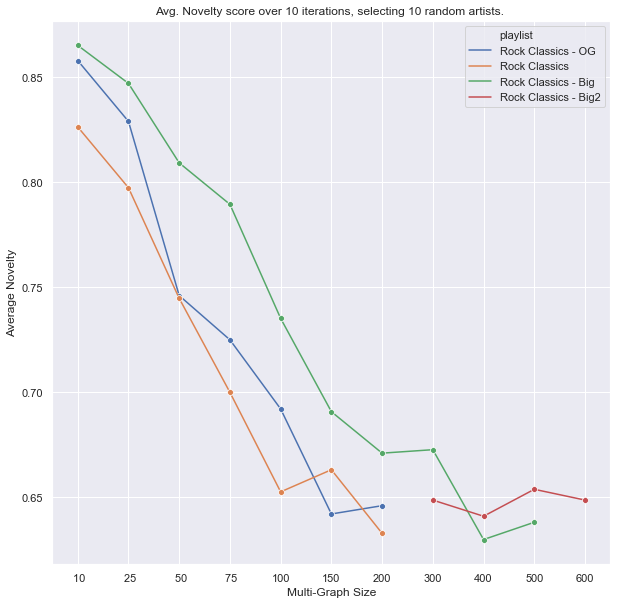

In [9]:
# find the mean score for each iteration for each playlist.

rockclassics_og_nov = {key[-3]+key[-2]+key[-1]:np.mean(rockclassics_og[key]) for key in rockclassics_og.keys()} 
rockclassics_nov = {key[-3]+key[-2]+key[-1]:np.mean(rockclassics[key]) for key in rockclassics.keys()} 
rockclassics_big = {key[-3]+key[-2]+key[-1]:np.mean(rockclassics_big[key]) for key in rockclassics_big.keys()} 
rockclassics_big2 = {key[-3]+key[-2]+key[-1]:np.mean(rockclassics_big2[key]) for key in rockclassics_big2.keys()} 
dicts = [rockclassics_og_nov, rockclassics_nov, rockclassics_big, rockclassics_big2]

names = ['Rock Classics - OG','Rock Classics', 'Rock Classics - Big', 'Rock Classics - Big2']

scores = pd.DataFrame()

count = 0
for i in dicts:   
    df = pd.DataFrame.from_dict(i,orient = 'index')
    df['playlist'] = names[count]
    scores = pd.concat([scores, df])
    count += 1
    
scores['novelty'] = scores[0]
scores['nodes'] = scores.index
scores.reset_index(inplace = True)

scores.drop(columns = [0, 'index'], inplace = True)

plt.figure(figsize = (10,10))
sns.lineplot(x = 'nodes',
             y = 'novelty',
             hue = 'playlist',
             marker = 'o',
             data = scores)
plt.xlabel('Multi-Graph Size')
plt.ylabel('Average Novelty')
plt.title('Avg. Novelty score over 10 iterations, selecting 10 random artists. ')
plt.show()

Testing out using raw popularity score instead of normalized on a multigraph with seed graphs of size 200, averaged over 10 iterations.  Also testing performance over different playlists.


In [13]:
def get_edges(dictionary,label, pop_weight = True, weight = 0):
    """Create a list of edges from a dictionary.

    Create a list of labeled edges for a network graph by comparing the values (artists)
    of each key (band) in a dictionary.  If two values share a key, return a list of
    (key,key,{link:shared value}) tuples.  This function is passed into the build_net function to
    generate the edge list for a graph.

    Parameters
    ----------
    dictionary : dict

    label : str
            Label to be used as key in edge metadata, used to describe node relationship.

    Returns
    -------
    edgelist : list of str and dict

    """
    edgelist = []
    for  key, value in dictionary.items():
        for items in value:
            for key1, value1 in dictionary.items():
                for items1 in value1:
                    if len(items) > 1 and len(items1) > 1: # Prevent single letter artists
                                                         # ('G' or 'K') from linking with
                                                         # every artist with a g or k in their name.                        
                        
                        if items in items1:
                            if pop_weight == True:
                                # adding to the edge attributes the average of the Yahoo! rating count between two artists
                                
                                #solve for df having multiple entires for artist ratings
                                if key in ratings.index:
                                    rating1 = ratings.loc[key, 'yahoo_rating_count'].astype(int)
                                    
                                    # TEMP - there may be multiple artists in the ratings file.  if this is the case,
                                    # select the first value in the series.  Remove when ratings file is consolidated. 
                                    if type(rating1) == pd.core.series.Series:
                                        rating1 = list(ratings.loc[key, 'yahoo_rating_count'])[0]
                                else:
                                    rating1 = 1
                                
                                if key1 in ratings.index:
                                    rating2 = ratings.loc[key1, 'yahoo_rating_count'].astype(int)
                                    
                                    if type(rating2) == pd.core.series.Series:
                                        rating2 = list(ratings.loc[key1, 'yahoo_rating_count'])[0]
                                else:
                                    rating2 = 1
                                
                                avg_rating = (rating1 + rating2) / 2 # average rating between two connected artists
                                                                     # ex. The Beatles (1000) <--> The Who (500)
                                                                     # = 750 edge weight.
                                 
                                norm_rating = avg_rating #/ 783871    
                                
                                # check to that the edge does not already exist in edge_list
                                if (key,key1,{label:items, 'weight':norm_rating}) not in edgelist:
                                    edgelist.append((key,key1,{label:items, 'weight':norm_rating}))
                            
                            # return edgelist without edge weight passed to function
                            else:
                                edgelist.append((key,key1,{label:items, 'weight':weight}))

    return edgelist


In [14]:
# for a playlist, compute the average novelty score from 10 iterations of selecting 
# 10 random artists and building graphs of size 10, 25, 50, 75, 100, 150, 200, 250

# - Print logging is not necessary but helpful to track the status of the loop.

novelty = {}

for i in [200]:
    
    print('building graph with  ', i, ' nodes')
    
    novelty_scores = []
    
    count = 0
         
    while count < 10 :                    # number of iterations over which an average will be taken.
                                         
        correct = 0 
              
        try:
            rand_artist_count = 0
            rand_artists = []
            while rand_artist_count < 10:                  # number of random artists
                rand = np.random.randint(0,num_artists,1)
                rand = rand[0]
                if artists[rand] not in rand_artists: #and artists[rand] not in ['mumford & sons','bløf','lil jon & the east side boyz']:
                    rand_artists.append(artists[rand].lower())
                    rand_artist_count +=1

            print("multigraph iteration: ", count+1)
            print(rand_artists)
            print(datetime.now())
            multigraph = layer_graphs(rand_artists, add_tags = True, size = i) # node count of each graph
            
            print(list(multigraph.edges.data())[1])  # print an edge w/ data to make sure edge weight is correct.
            
            print("scores iteration: ", count+1)
            print(datetime.now())
        
            scores = new_centrality(multigraph)

            scores.sort_values(by = ['page_rank'],
                               ascending = False,
                               inplace = True)
            topN = list(scores['artist'].iloc[:num_artists])
            for artist in topN:
                 if artist in artists:
                        correct += 1    

            accuracy = correct / num_artists
            
            novelty_scores.append(1 - accuracy)
            
            count += 1
        except:
            count +=1
               
    novelty[str(playlist_name+' '+str(i))] = novelty_scores
        
novelty  

building graph with   200  nodes
multigraph iteration:  1
['simple minds', 'various artists', 'whitney houston', 'steve winwood', 'talking heads', 'boy george', 'daryl hall & john oates', 'the j. geils band', 'men at work', 'billy ocean']
2020-05-10 16:33:30.850970
('simple minds', 'foreigner', {'Artist': 'mark schulman', 'weight': 119224.0})
scores iteration:  1
2020-05-10 16:36:25.027777
multigraph iteration:  2
['billy ocean', 'various artists', 'pat benatar', 'whitney houston', 'genesis', 'the j. geils band', 'rod stewart', 'boy george', 'steve winwood', 'phil collins']
2020-05-10 16:42:21.945116
('various artists', 'various artists', {'Artist': 'william kelly stair', 'weight': 692.0})
scores iteration:  2
2020-05-10 16:45:32.342045
multigraph iteration:  3
['blondie', 'don henley', 'eddy grant', 'genesis', 'daryl hall & john oates', 'boy george', 'the j. geils band', 'michael jackson', 'tears for fears', 'rod stewart']
2020-05-10 16:51:00.493029
eddy grant  not in artist_dictionar

{'80s summer mix 200': [0.8723404255319149,
  0.851063829787234,
  0.8723404255319149,
  0.8936170212765957,
  0.8297872340425532,
  0.8723404255319149,
  0.8297872340425532,
  0.851063829787234,
  0.8723404255319149,
  0.8936170212765957]}

In [15]:
novelty

{'80s summer mix 200': [0.8723404255319149,
  0.851063829787234,
  0.8723404255319149,
  0.8936170212765957,
  0.8297872340425532,
  0.8723404255319149,
  0.8297872340425532,
  0.851063829787234,
  0.8723404255319149,
  0.8936170212765957]}

In [16]:
summer_hits_80s = novelty
summer_hits_80s

{'80s summer mix 200': [0.8723404255319149,
  0.851063829787234,
  0.8723404255319149,
  0.8936170212765957,
  0.8297872340425532,
  0.8723404255319149,
  0.8297872340425532,
  0.851063829787234,
  0.8723404255319149,
  0.8936170212765957]}

In [1]:
rock_classics200 = {'rock classics 200': [0.5810810810810811,
  0.6756756756756757,
  0.6216216216216216,
  0.6351351351351351,
  0.6351351351351351,
  0.5945945945945945,
  0.6351351351351351,
  0.6756756756756757,
  0.6216216216216216,
  0.5810810810810811]}

In [1]:
import networkx as nx
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from collections import Counter
import warnings
import os
import time
#import nxviz as nv
from scipy import stats
from datetime import datetime
from sklearn import metrics

warnings.filterwarnings('ignore')  # suppress warning messages
get_ipython().run_line_magic('matplotlib', 'inline')
sns.set()

# Import artist_dictionary.data, tags_dict.data, and yahoo ratings.csv
# from working directory.

artist_dictionary = pickle.load(open('artist_dictionary.data','rb'))
tags_dictionary = pickle.load(open('tags_dict.data','rb'))
filtered_tags_dictionary = pickle.load(open('filtered_tags_dict.data','rb'))

ratings = pd.read_csv('artist-yahoo-ratings.csv')
ratings['artist'] = ratings['artist_name'].str.lower()
ratings = ratings.set_index('artist')
# fill missing ratings with 0 and convert column to integer
ratings['yahoo_rating_count'] = ratings['yahoo_rating_count'].fillna(0).astype(int)

spotify_rankings = pd.read_csv('10k_spotify_rankings.csv')

spotify_rankings['Artist'] = spotify_rankings['Artist'].str.lower()

# lower-case all artists - also running at end of cell to make manually adding artists easier

artist_dictionary = {str(key).lower():artist_dictionary[key] for key in artist_dictionary.keys()}

for key in artist_dictionary.keys():
    artist_dictionary[key]=[i.lower() for i in artist_dictionary[key]]

tags_dictionary = {str(key).lower():tags_dictionary[key] for key in tags_dictionary.keys()}

for key in tags_dictionary.keys():
    tags_dictionary[key]=[str(i).lower() for i in tags_dictionary[key]]


filtered_tags_dictionary = {str(key).lower():filtered_tags_dictionary[key] for key in filtered_tags_dictionary.keys()}

for key in filtered_tags_dictionary.keys():
    filtered_tags_dictionary[key]=[str(i).lower() for i in filtered_tags_dictionary[key]]

#remove duplicate values from each key
artist_dictionary = {key:list(set(artist_dictionary[key])) for key in artist_dictionary.keys()}
tags_dictionary = {key:list(set(tags_dictionary[key])) for key in tags_dictionary.keys()}



def build_net(seed, goal=None, size=600, graph=True):
    """ Build an artist-based network graph.

    Create an undirected, artist-based network graph with labeled edges. Basic
    graph structure is equivelant to (band1) <-- shared artist --> (band2). By
    default, function will build networks of size 600 (node count / bands.)
    Optionally, the function can also produce a network that starts with a
    band (seed) and builds a network until it contains the a second band (goal.)
    Warning! There is no check for whether two bands reside in the same network.  It is
    possible to specify a seed and goal for which a relationship does not exist.

    Parameters
    ----------
    seed : str
           Seed band around wihch a network graph is built.  Also root of tree search.

    goal : str
            The function will stop growing the network graph once it contains the goal (band).
            Optional, default = None.

    size : int
           Size of the network graph, defined by node count.
           Optional, default = 600 nodes (bands.)

    graph : bool
            True = return graph object, False = return node/edge lists.

    Returns
    -------
    graph : networkX graph object
            if graph=True, return undirected graph

    nodes,edges : list of str
                  if graph=False, return node and edge lists

    """
    artist_list = []
    band_list = []

    artistindex = 0  # Use index markers to keep track of progress and
    bandindex = 0    # avoid iterating over the entire artist and band lists.

    band_list.append(seed)  # Level 1 seed band (root).

    if goal is not None:

        if nx.has_path(seed,goal) == True:  # Check that a path between seed and goal exists.

            while goal not in band_list:
                for band in band_list[bandindex:]:               # Only retrieve artists for 'new' bands
                    for artist in artist_dictionary[band]:       # in band_list.
                        if artist not in artist_list:
                            artist_list.append(artist)           # Add new artists to artist_list.

                bandindex = len(band_list)                       # Mark current bands in band_list as 'worked'
                                                                 # by setting index marker to the first index
                                                                 # following last element in band_list.

                for artist in artist_list[artistindex:]:         # Only retrieve bands for 'new' artists
                    for key, value in artist_dictionary.items(): # in artist_list.
                        if artist in value:
                            if key not in band_list:
                                if goal not in band_list:
                                    band_list.append(key)        # Add new bands to band_list.

                artistindex = len(artist_list)                  # Mark current artists in artist_list as 'worked'
                                                                 # by setting index marker to the first index
        else:                                                    # following the last element in artist_list.

            print('A path between ',seed,' and ',goal,' does not exist.')


    else:
        prev_band_len = 0
        prev_art_len = 0
        go = True                                   # exit var will flip and end loop if no new artists 
                                                    # are added to the band list (see note below)
        while len(band_list) < size and go == True:

            if len(band_list) > prev_band_len or len(artist_list) > prev_art_len:  # check that the len of bandlist has increased, if not
                prev_art_len = len(artist_list)         # set go = no.  added to prevent infinite loops caused
                prev_band_len = len(band_list)          # by artists who have only worked solo ex Madonna.

                for band in band_list[bandindex:]:
                    for artist in artist_dictionary[band]:
                        if artist not in artist_list:
                            artist_list.append(artist)

                bandindex = len(band_list) -1

                for artist in artist_list[artistindex:]:
                    for key, value in artist_dictionary.items():
                        if artist in value:
                            if key not in band_list:
                                if len(band_list) < size:
                                    band_list.append(key)

                artistindex = len(artist_list) -1


            else:
                go = False

    dictionary = {band : artist_dictionary[band] for band in band_list}  # local artist dictionary

    for key, value in dictionary.items():
        dictionary[key] = set(value)   # filter out duplicate group members.

    nodes = list(dictionary.keys())

    edges = get_edges(dictionary, 'Artist', pop_weight = True)

    for i in edges:              # remove single edge loops from edge list
            if i[0] == i[1]:     # ex. ('The Who','The Who',{'artist':'Roger Daltrey'})
                edges.remove(i)

    if graph == False:

        return(nodes, edges)

    else:
        net_graph = nx.MultiGraph()
        net_graph.add_nodes_from(nodes)
        net_graph.add_edges_from(edges)
        return(net_graph)



# In[ ]:


def add_tag_edges(graph, just_edges=False):
    """Add user tag-based edges to an existing artist network graph.

    Append user tag-based edges to an existing artist graph and return a
    multigraph. Creates edges in the form of (band1,band2,{link:tag})
    tuple.  This function will not add new nodes to the graph.

    Parameters
    ----------
    graph : graph object
            Network graph from which tags will be retrieved, and tag-edges will be added

    just_edges : bool
                 If just_edges = True, return new, undirected multigraph object.
                 If just_edges = False, return list of tag-based edges.

    Returns
    -------
    new_graph : networkX multigraph object

    tag_edges : list of str

    """

    new_graph = nx.MultiGraph()

    #new_graph.add_nodes_from(graph.nodes()) # add nodes from original graph

    new_graph.add_edges_from(graph.edges.data()) # add edges w/attribute dictionary from original graph

    bands = [node for node in graph.nodes()]

    dictionary = {band : tags_dictionary[band] for band in bands
                  if band in tags_dictionary.keys()}  # Check if band exists as a key in
                                                      # in tags_dictionary.

    #if len(dictionary.keys()) >= 2:                   # comparing keys requires atleast two keys
    tag_edges = get_edges(dictionary,'User-Tag', pop_weight = False, weight = 0.005)

    for i in tag_edges:          # remove single edge loops from edge list
        if i[0] == i[1]:         # ex. ('The Who','The Who',{'LINK':'classic rock'})
            tag_edges.remove(i)

    if len(tag_edges) > 0:
        if just_edges == True:

            return tag_edges

        else:
            new_graph.add_edges_from(tag_edges)

            return new_graph


# In[ ]:


def new_centrality(graph):
    """ Compute centrality scores for a network graph.

    Compute a number of different centrality and misc. scores for all nodes in a network graph.

    Parameters
    ----------
    graph : networkX graph object

    Returns
    -------
    core_df : Pandas DataFrame object

    """

    core_df = pd.DataFrame()
    core_df['artist'] = graph.nodes() # Add to the artist column all nodes (artists) in a graph.
    scores_list = []

    try:
        deg_cent = pd.DataFrame.from_dict(nx.degree_centrality(graph), orient = 'index',  columns = ['deg_cent'])
        scores_list.append(deg_cent)
    except:
        pass

    try:
        load_cent = pd.DataFrame.from_dict(nx.load_centrality(graph), orient = 'index',  columns = ['load_cent'])
        scores_list.append(load_cent)
    #between_cent = nx.betweenness_centrality(graph)
    except:
        pass

    
    """ 5/7/2020 - added weight = 'rating_weight' to scoring function'"""
    try:
        page_rank = pd.DataFrame.from_dict(nx.pagerank_numpy(graph, weight = 'rating_weight'),
                                           orient = 'index',  
                                           columns = ['page_rank'])
        scores_list.append(page_rank)
    except:
        pass

    try:
        ev_cent = pd.DataFrame.from_dict(nx.eigenvector_centrality_numpy(graph), orient = 'index',  columns = ['ev_cent'])
        scores_list.append(ev_cent)
    except:
        pass

    try:
        cl_cent = pd.DataFrame.from_dict(nx.closeness_centrality(graph), orient = 'index',  columns = ['close_cent'])
        scores_list.append(cl_cent)
    except:
        pass

    try:
        cfcc = pd.DataFrame.from_dict(nx.current_flow_closeness_centrality(graph), orient = 'index',  columns = ['cf_close_cent'])
        scores_list.append(cfcc)
    except:
        pass
    """
    try:
        ic = pd.DataFrame.from_dict(nx.information_centrality(graph), orient = 'index',  columns = ['info_cent'])
        scores_list.append(ic)
    except:
        pass

        #ebc = pd.DataFrame.from_dict(nx.edge_betweenness_centrality(graph), orient = 'index',  columns = ['edge_bet_cent'])

    try:
        cfbc = pd.DataFrame.from_dict(nx.current_flow_betweenness_centrality(graph), orient = 'index',  columns = ['edge_cflow_cent'])
        scores_list.append(cfbc)
    except:
        pass
    #ecfbc = pd.DataFrame.from_dict(nx.edge_current_flow_betweenness_centrality(graph), orient = 'index',  columns = ['cf_between_cent'])

    try:
        acfbc = pd.DataFrame.from_dict(nx.approximate_current_flow_betweenness_centrality(graph), orient = 'index',  columns = ['appx.cfbt_cent'])
        scores_list.append(acfbc)
    except:
        pass
    #elc = pd.DataFrame.from_dict(nx.edge_load_centrality(graph), orient = 'index',  columns = ['edge_load_cent'])
    """
    try:
        hc = pd.DataFrame.from_dict(nx.harmonic_centrality(graph), orient = 'index',  columns = ['harm_cent'])
        scores_list.append(hc)
    except:
        pass
    #d = pd.DataFrame.from_dict(nx.dispersion(graph), orient = 'index',  columns = ['dispersion'])
    """
    try:
        soc = pd.DataFrame.from_dict(nx.second_order_centrality(graph), orient = 'index',  columns = ['sec_ord_cent'])
        scores_list.append(soc)
    except:
        pass
    """
    df = pd.concat(scores_list, axis = 1)

    core_df = core_df.merge(df,
                            left_on = 'artist',
                            right_index = True)

    core_df['mean_cent'] = core_df.apply(lambda row: np.mean(row[1:]),   #  Calculate the mean of the row
                                    axis = 1)
    return core_df


# In[ ]:


def layer_graphs(artists, add_tags = True,  size = 600):
    """Layer n artist networks together.

    Layer together multiple artist-based graphs, add tag-based edges,
    and return a single multigraph.

    Parameters
    ----------
    args : str
           Band(s) around which network graphs will be built and a layered
           together.
    size : int
           Size in # of nodes for the individual artist networks.

    Returns
    -------
    graph : networkX multigraph object

    """
    layered_graph = nx.MultiGraph()

    for band in artists:
        if band in artist_dictionary.keys():

            artist_graph = build_net(band, size = size)  # Build the artist-based network

            layered_graph.add_edges_from(artist_graph.edges.data())  # Add edges to layered_graph, nodes
                                                                # will be added if they do not already exist.
        else:
            print(band, ' not in artist_dictionary')

    if add_tags == True:
        layered_graph = add_tag_edges(layered_graph)  # Add tag-based edges to layered_graph and
                                                  # connect the artist graph layers.

    return layered_graph


# In[ ]:


"""  This is a catch-all section for manually adding missing artists and bands
to the artist dictionary.  They will eventually be moved intoartist_dictionary.data.
One day..."""

artist_dictionary['bob seger'] = ['bob seger']
artist_dictionary['tom petty'] = ['tom petty']
artist_dictionary['phil collins'] = ['phil collins']
artist_dictionary['madonna'] = ['madonna']
artist_dictionary['the english beat'] = artist_dictionary['the beat']
artist_dictionary['gloria estefan'] = ['gloria estefan']
artist_dictionary['don henley'] = ['don henley']
artist_dictionary['daryl hall & john oates'] = artist_dictionary['hall & oates']
artist_dictionary['boy george'] = ['boy george']
artist_dictionary['a-ha'] = ['magne furuholmen', 'morten harket','paul waaktaar-savoy']
artist_dictionary['huey lewis & the news'] = artist_dictionary['huey lewis and the news']
artist_dictionary['ilse delange'] =  ['ilse delange']
artist_dictionary['chris isaak'] = ['chris isaak']
artist_dictionary['vanessa carlton'] = ['vanessa carlton']
artist_dictionary['alicia keys'] = ['alicia keys']
artist_dictionary['adele'] = ['adele']
artist_dictionary['amy winehouse'] = ['amy winehouse']
artist_dictionary['rihanna'] = ['rihanna']
artist_dictionary['marco borsato']= ['marco borsato']
artist_dictionary['mary j. blige'] = ['mary j. blige']
artist_dictionary['amy macdonald'] = ['amy macdonald']
artist_dictionary['tom jones'] = ['tom jones']
artist_dictionary['george michael'] = ['george michael']
artist_dictionary['james morrison'] = ['james morrison']
artist_dictionary['iggy pop'] = ['iggy pop']
artist_dictionary['joan osborne'] = ['joan osborne']
artist_dictionary['anti-flag'] = ['andy wright', 'justin sane', 'pat thetic','chris head']
artist_dictionary['kayzo'] = ['kayzo']
artist_dictionary['fame on fire'] = ['bryan kuznitz', 'blake saul', 'paul spirou', 'alex roman']
artist_dictionary['rev theory'] = ['rich luzzi', 'julien jorgensen','rikki lixx','matt mccloskey','dave agoglia']
artist_dictionary['the anix'] = ['brandon smith', 'logan smith','chris dinger']
artist_dictionary['ded'] = ['joe cotela', 'kyle koelsch', 'david ludlow', 'matt reinhard']
artist_dictionary['blind channel'] = ['joel hokka', 'niko moilanen', 'joonas porko', 'olli matela', 'tommi lalli']
artist_dictionary['mammoth mammoth'] = ['mikey tucker', 'ben couzens', 'frank trobbiani','pete bell','gareth sweet','simon jaunay','marco gennaro','kris sinister']
artist_dictionary['dayseeker'] = ['rory rodriguez', 'mike karle', 'alex polk', 'gino sgambelluri','andrew sharp']
artist_dictionary['dream state'] = ['charlotte gilpin', 'aled evans', 'rhys wilcox', 'danny rayer', 'sam harrison-little', 'jamie lee']
artist_dictionary['wage war'] = ['briton bond', 'cody quistad',  'seth blake', 'jordan pierce', 'david rau', 'chris gaylord', 'stephen kluesener']
artist_dictionary['soulja boy'] = ['']
artist_dictionary['fergie'] = ['fergie']
artist_dictionary['pitbull'] = ['pitbull']
artist_dictionary['ne-yo'] = ['ne-yo']
artist_dictionary['jessie j'] = ['jessie j']
artist_dictionary['nicki minaj'] = ['nicki minaj']
artist_dictionary['jennifer lopez'] = ['jennifer lopez']
artist_dictionary['chris brown'] = ['chris brown']
artist_dictionary['justin bieber'] = ['justin bieber']
artist_dictionary['taio cruz'] = ['taio cruz']
artist_dictionary['jason derulo'] = ['jason derulo']
artist_dictionary['flo rida'] = ['flo rida']
artist_dictionary['iyaz'] = ['iyaz']
artist_dictionary['black eyed peas'] = artist_dictionary['the black eyed peas']
artist_dictionary['alexandra stan'] = ['alexandra stan']
artist_dictionary['david guetta'] = ['david guetta']
artist_dictionary['fidlar'] = ['zac carper', 'elvis kuehn', 'max kuehn','brandon schwartzel']

artist_dictionary["swingin' utters"] = ['kevin wickersham','greg mcentee', 'darius koski', 'max huber', 'spike slawson','jack dalrymple', 'miles peck']
artist_dictionary['the 4-skins'] = ['steve harmer','gary hodges','tom mccourt']
artist_dictionary['4 skins'] = artist_dictionary['the 4-skins']
artist_dictionary['jfa']=['Mike Tracy','Brian Brannon','Don Pendleton','Corey Stretz','Todd Barnes',                          'Alan Bishop','Scott Chazan','Michael Cornelius','Bob Cox','Brian Damage',                          'Joel DuBois','Trace Element','Matt Etheridge','Jim Moore','Don Pendelton',                          'Al Penzone','Jaime Reidling','Mike Sversvold','Bruce Taylor','Mike Tracy']
artist_dictionary['nihilistics'] = ['Dave Phinster','Mike King','Ron Rancid','Ajax Lepinski']
artist_dictionary['the neighborhoods'] = ['Dave Minehan','John Hartcorn', 'Michael Quaglia']
artist_dictionary['nobodys'] = ['Geoff Palmer', 'J. J. Nobody', 'Justin Disease', 'Randy The Kid']
artist_dictionary['china white'] = ['Marc Martin','James Rodriguez','Joey Ruffino','Frank Ruffino',                                    'Scott Sisunik','Richard Katchadoorian','Vince Mesa','Corey Stretz',                                    'Steven Barrios','Jeff Porter','James Lugo','Sandy Hancock']
artist_dictionary['the fairlanes'] = ['Andy Baldwin', 'Jason Zumbrunnen', 'Robbie Kalinowski', 'Scott Weigel']
artist_dictionary['pink lincolns'] = ['Chris Barrows','Dorsey Martin','Kevin Coss','Jeff Fox']
artist_dictionary['zeke'] = ['Blind Marky Felchtone','Kyle Whitefoot','Kurt Colfelt','Dayne Porras',                             'Jeff Hiatt','Chris Johnsen','Buzzy','Kurt Colfelt','Jeff Matz',                             'Mark Pierce','Abe Zanuel Riggs III','Dizzy Lee Roth','Donny Paycheck']
artist_dictionary['x-ray spex'] = ['B.P. Hurding','Poly Styrene','Steve Thompson','Lora Logic']
artist_dictionary['fidlar'] = ['Zac Carper','Elvis Kuehn','Max Kuehn','Brandon Schwartzel']
artist_dictionary['johnny thunders & the heartbreakers'] = artist_dictionary['the heartbreakers']
artist_dictionary['mike v & the rats'] = ['Jason Hampton', 'Mike Vallely', 'P.T. Pugh', 'Reid Black']
artist_dictionary['g-eazy'] = ['g-eazy']
artist_dictionary['post malone'] = ['post malone']
artist_dictionary['lil skies'] = ['lil skies']
artist_dictionary['lil mosey'] = ['lil mosey']
artist_dictionary['youngboy never broke again'] = ['youngboy never broke again']
artist_dictionary['a boogie wit da hoodie'] =['a boogie wit da hoodie']
artist_dictionary['lil baby'] = ['ll baby']
artist_dictionary['pnb rock'] = ['pnb rock']
artist_dictionary['tee grizzley'] = ['tee grizzley']
artist_dictionary['meek mill'] = ['meek mill']
artist_dictionary['lil zay osama'] = ['lil zay osama']
artist_dictionary['montana of 300'] = ['montana of 300']
artist_dictionary['playboi'] =['playboi']
artist_dictionary['strap da fool'] = ['strap da fool']
artist_dictionary['lil durk'] = ['lil durk']
artist_dictionary['juice wrld'] = ['juice wrld']
artist_dictionary['quando rondo'] = ['quando rondo']
artist_dictionary['yk osiris'] = ['yk osiris']
artist_dictionary['pnb meen'] = ['pnb meen']
artist_dictionary['lil uzi vert'] = ['lil uzi vert']
artist_dictionary['knuckle puck'] =['Joe Taylor','Kevin Maida','John Siorek','Nick Casasanto','Ryan Rumchaks']
artist_dictionary['the story so far'] = ['Parker Cannon','Kelen Capener','Kevin Geyer','Will Levy','Ryan Torf']


artist_dictionary = {str(key).lower():artist_dictionary[key] for key in artist_dictionary.keys()}
for key in artist_dictionary.keys():
    artist_dictionary[key]=[i.lower() for i in artist_dictionary[key]]
